# Caltech101
## Label = "starfish", "Faces_easy","grand_piano","watch","ketch","sunflower"
## param : 1,174,358
## accuracy : 0.97

In [1]:
## 그대로 ##
#https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
## remove core ##
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# pip install imutils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
# <Option 1> You need to import GlobalAveragePooling2D if you want to use GAP model
#from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import backend as K

In [3]:
## 수정(핵심) ##
class StridedNet:
	@staticmethod
	def build(width, height, depth, classes, reg, init="he_normal"):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# our first CONV layer will learn a total of 16 filters, each
		# Of which are 7x7 -- we'll then apply 2x2 strides to reduce
		# the spatial dimensions of the volume
		# model.add(Conv2D(16, (7, 7), strides=(2, 2), padding="valid", kernel_initializer=init, kernel_regularizer=reg, input_shape=inputShape))
        # 이거 부터 수정 시작하기(conv2D(16,(7,7)))
        # maxpooling (2,2)
        
        # 1. Conv + BatchNormalization + MaxPool + Dropout
		model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=inputShape, kernel_initializer=init, kernel_regularizer=reg))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(16, (5, 5), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(BatchNormalization(axis=chanDim))        
		model.add(MaxPooling2D(pool_size=(2, 2)))
# 		model.add(Dropout(0.3))
        
		# here we stack two CONV layers on top of each other where
		# each layerswill learn a total of 32 (3x3) filters
		#NK: <Option 2> You SHOULD design your own CNN models based on StrideNet (old) model
		#NK: Five components of Convolution layer: Conv2D, BatchNormalization, Maxpooling2D, Dropout, Flatten or GlobalAveragePooling2D
		#NK: <Option 3> Conv2, same padding, stride (2,2) is essentially same as MaxPooling2D
		#NK: You can change following lines to MaxPooling2D
        
        # 2. [Conv + BatchNormalization]*2 + MaxPool + Dropout
		model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (5, 5), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(BatchNormalization(axis=chanDim))
# 		model.add(Conv2D(32, (5, 5), padding="same", kernel_initializer=init, kernel_regularizer=reg))
# 		model.add(BatchNormalization(axis=chanDim))
# 		model.add(Conv2D(32, (5, 5), padding="same", kernel_initializer=init, kernel_regularizer=reg))
# 		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))        
# 		model.add(Dropout(0.3))
        
		#NK: stack two more CONV layers, keeping the size of each filter
		#NK: as 3x3 but increasing to 64 total learned filters
		#NK: <Option 3> Conv2, same padding, stride (2,2) is essentially same as MaxPooling2D
		#NK: You can change following lines to MaxPooling2D
        
        # 3. [Conv + BatchNormalization]*2 + MaxPool + Dropout
		model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (5, 5), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (5, 5), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))        
# 		model.add(Dropout(0.3))

		# increase the number of filters again, this time to 128
		#NK: <Option 3> Conv2, same padding, stride (2,2) is essentially same as MaxPooling2D
		#NK: You can change following lines to MaxPooling2D
        
        # 4. [Conv + BatchNormalization]*2 + MaxPool + Dropout
		model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (5, 5), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (5, 5), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))        
# 		model.add(Dropout(0.3))

		#NK: <Option 4> You can convert Flatten into GlobalAveragePooling2D, but you have to make sure that you have enough numbers of filters
		#NK: If the number of filter is small, performance of GlobalAveragePooling2D is not that good
		# fully-connected layer
# 		model.add(Flatten())

        # 5. Global Average Pooling
		model.add(GlobalAveragePooling2D())
		#NK: <Option 5> You can add FC (fully connected) layers, up to 2 times
		#NK: 3 or more FC layers are not recommended due to long calculation time and increase of parameters
		model.add(Dense(128, kernel_initializer=init, activation = 'relu'))
		model.add(BatchNormalization())
		#NK: <Option 6> You can change ratio of Dropout depending on how large is the image space you need in CNN model
# 		model.add(Dropout(0.3))

		#NK: <Caveat> DO NOT CHANGE THIS PART, FINAL LAYER SHOULD BE Dense(#class) with softmax
		# softmax classifier
		model.add(Dense(classes, activation = 'softmax'))

		# return the constructed network architecture
		return model

In [4]:
## 수정("Faces", "Leopards", "Motorbikes", "airplanes" 제외, 100개 이상 이미지 추천) ##
# initialize the set of labels from the CALTECH-101 dataset we are
# going to train our network on
# LABELS = set(["Faces", "Leopards", "Motorbikes", "airplanes"])
LABELS = set(["starfish", "Faces_easy","grand_piano","watch","ketch","sunflower"])

In [5]:
## 그대로 ##
#imagedir = 'CALTECH101_ObjectCategories'
imagefilename = 'D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTECH101_ObjectCategories.zip'
import zipfile
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(imagedir))
zf = zipfile.ZipFile(imagefilename)
imagelist = zf.namelist()
data = []
labels = []

[INFO] loading images...


In [6]:
## 그대로 ##
# loop over the image paths
#for imagePath in imagePaths:
for imagePath in imagelist:
	# extract the class label from the filename
	#print(imagePath.split(os.path.sep), os.path.sep)
	#label = imagePath.split(os.path.sep)[-2]
	label = imagePath.split('/')[-2]

	# if the label of the current image is not part of of the labels
	# are interested in, then ignore the image
	if label not in LABELS:
		continue

	# load the image and resize it to be a fixed 96x96 pixels,
	# ignoring aspect ratio
	imagedata = zf.read(imagePath)
	#image = cv2.imread(imagePath)
	image = cv2.imdecode(np.frombuffer(imagedata, np.uint8), 1)
	image = cv2.resize(image, (96, 96))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

In [7]:
## 그대로 ##
# convert the data into a NumPy array, then preprocess it by scaling
# all pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0

In [8]:
## 그대로 ##
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [9]:
## 그대로 ##
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
#NK: <Caveat> DO NOT CHANGE THIS PART, 25% OF DATA WILL BE USED AS TEST SET
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)

In [10]:
## 그대로 ##
# construct the training image generator for data augmentation
#NK: You can do image augmentation further to increase your performance
#NK: Check the option of ImageDataGenerator for further processing
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [14]:
## epochs, optimizers, regulators 수정가능 ##
#NK: You can change # of epochs, optimizers, and regulators
#NK: K2 regularizer Strong 0.01 ~ Week 0.0001
maxepoch = 150
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=1e-4, decay=1e-4 / maxepoch)
model = StridedNet.build(width=96, height=96, depth=3, classes=len(lb.classes_), reg=l2(0.00005))
## 그대로 ##
#NK: <Caveat> DO NOT CHANGE LOSS FUNCTION, SOFTWARE CLASSFIER ALWAYS USE CATEGORICAL_CROSSTNEROPY
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [12]:
## 그대로 ##
#NK: You have to check dimension of each layers before doing model.fit
#NK: Tensorflow will automatically calculate dimensional changes between layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        6416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        1

In [15]:
## callback 추가 ##
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 5번 동안 개선되지 않으면 종료(val_loss 를 관찰함)
es = EarlyStopping(patience=25, verbose=1)
# learning rate scheduler
reLR = ReduceLROnPlateau(monitor = 'val_loss', patience=15, verbose=1, factor=0.5)
#NK: 25% of test dataset is feeded into CNN model by "validation_data"
# train the network
print("[INFO] training network for {} epochs...".format(maxepoch))
H = model.fit(aug.flow(trainX, trainY, batch_size=64), validation_data=(testX, testY), steps_per_epoch=len(trainX) // 64, epochs=maxepoch, verbose=1, callbacks=[es,reLR])
#batch_size: 32->10 for small GPU memory

[INFO] training network for 150 epochs...
Epoch 1/150
12/12 [==============================] - 2s 145ms/step - loss: 1.4822 - accuracy: 0.5377 - val_loss: 29.3064 - val_accuracy: 0.1509
Epoch 2/150
12/12 [==============================] - 1s 123ms/step - loss: 1.0121 - accuracy: 0.7051 - val_loss: 10.1322 - val_accuracy: 0.2981
Epoch 3/150
12/12 [==============================] - 1s 119ms/step - loss: 0.8656 - accuracy: 0.7490 - val_loss: 7.1825 - val_accuracy: 0.1887
Epoch 4/150
12/12 [==============================] - 1s 121ms/step - loss: 0.8429 - accuracy: 0.7545 - val_loss: 5.0829 - val_accuracy: 0.5245
Epoch 5/150
12/12 [==============================] - 1s 117ms/step - loss: 0.7395 - accuracy: 0.8011 - val_loss: 6.4035 - val_accuracy: 0.5094
Epoch 6/150
12/12 [==============================] - 1s 120ms/step - loss: 0.6775 - accuracy: 0.8011 - val_loss: 5.5363 - val_accuracy: 0.4981
Epoch 7/150
12/12 [==============================] - 1s 124ms/step - loss: 0.6634 - accuracy: 0.80

11/12 [==========================>...] - ETA: 0s - loss: 0.1287 - accuracy: 0.9858
Epoch 00113: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
12/12 [==============================] - 1s 115ms/step - loss: 0.1340 - accuracy: 0.9849 - val_loss: 0.1748 - val_accuracy: 0.9660
Epoch 114/150
12/12 [==============================] - 1s 121ms/step - loss: 0.1234 - accuracy: 0.9877 - val_loss: 0.1702 - val_accuracy: 0.9774
Epoch 115/150
12/12 [==============================] - 1s 114ms/step - loss: 0.1194 - accuracy: 0.9918 - val_loss: 0.1584 - val_accuracy: 0.9774
Epoch 116/150
12/12 [==============================] - 1s 118ms/step - loss: 0.1248 - accuracy: 0.9822 - val_loss: 0.1648 - val_accuracy: 0.9736
Epoch 117/150
12/12 [==============================] - 1s 115ms/step - loss: 0.1268 - accuracy: 0.9877 - val_loss: 0.1695 - val_accuracy: 0.9736
Epoch 118/150
12/12 [==============================] - 1s 111ms/step - loss: 0.1174 - accuracy: 0.9890 - val_loss: 0.1624 - va

In [16]:
## 그대로 ##
#NK: Your performance of CNN model will be evaluated by precision, recall and f1-score
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

  Faces_easy       1.00      1.00      1.00       109
 grand_piano       0.96      0.96      0.96        25
       ketch       1.00      0.97      0.98        29
    starfish       0.86      0.86      0.86        21
   sunflower       0.95      0.90      0.93        21
       watch       0.97      1.00      0.98        60

    accuracy                           0.97       265
   macro avg       0.96      0.95      0.95       265
weighted avg       0.97      0.97      0.97       265



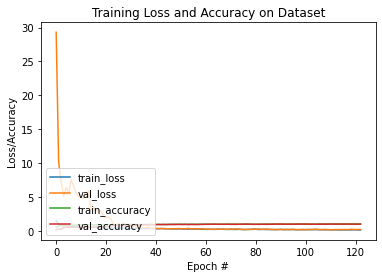

In [17]:
## 그대로 ##
# 만약 early stopping 했다면, maxepoch을 early stopping한 epoch에 맞춰줘야함
# plot the training loss and accuracy
import matplotlib
%matplotlib inline
plt.figure()
plt.plot(np.arange(0, 123), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 123), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 123), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, 123), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()